In [1]:
from transformers import AutoTokenizer, AutoModel, AutoProcessor
import torch
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384")
model = model.to("mps")
tokenizer = AutoTokenizer.from_pretrained("google/siglip-so400m-patch14-384")
processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384")

In [4]:
image = Image.fromarray(np.random.randint(0, 2, (4, 3)).astype(float) * 255).resize((384, 384), Image.NEAREST)

n = 2 ** (4 * 3)

imgs = []

for i in range(n):
    base_2_i = format(i, f"0{4*3}b")
    img = np.array([int(x) for x in base_2_i]).reshape(4, 3)
    img = Image.fromarray(img.astype(float) * 255).resize((384, 384), Image.NEAREST).convert("RGB")
    imgs.append(img)


batch_size = 8

image_features = []

for i in tqdm(range(0, n, batch_size)):
    inputs = processor(images=imgs[i:i+batch_size], return_tensors="pt")
    inputs = {k: v.to("mps") for k, v in inputs.items()}
    with torch.no_grad():
        batch_image_features = model.get_image_features(**inputs)
        batch_image_features = batch_image_features.cpu().detach().numpy()

    image_features.append(batch_image_features)


image_features = np.concatenate(image_features, axis=0)
# np.save("image_features.npy", image_features)

  0%|          | 0/512 [00:00<?, ?it/s]

In [5]:
image_features.shape

(4096, 1152)

In [251]:
alphabet = "abcdefghijklmnopqrstuvwxyz"

prompt = lambda letter: f"the letter {letter}"

letter_features = []

for i in tqdm(range(0, len(alphabet), batch_size)):
    inputs = tokenizer([prompt(letter) for letter in alphabet[i:i+batch_size]], padding="max_length", return_tensors="pt")
    inputs = {k: v.to("mps") for k, v in inputs.items()}
    with torch.no_grad():
        batch_letter_features = model.get_text_features(**inputs)
        batch_letter_features = batch_letter_features.cpu().detach().numpy()

    letter_features.append(batch_letter_features)

letter_features = np.concatenate(letter_features, axis=0)

  0%|          | 0/4 [00:00<?, ?it/s]

In [252]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cos_similarity(A, B):
    return np.dot(A, B.T) / (np.linalg.norm(A) * np.linalg.norm(B))

def siglip_similarity(image_features, letter_features):
    return sigmoid(cos_similarity(image_features, letter_features))

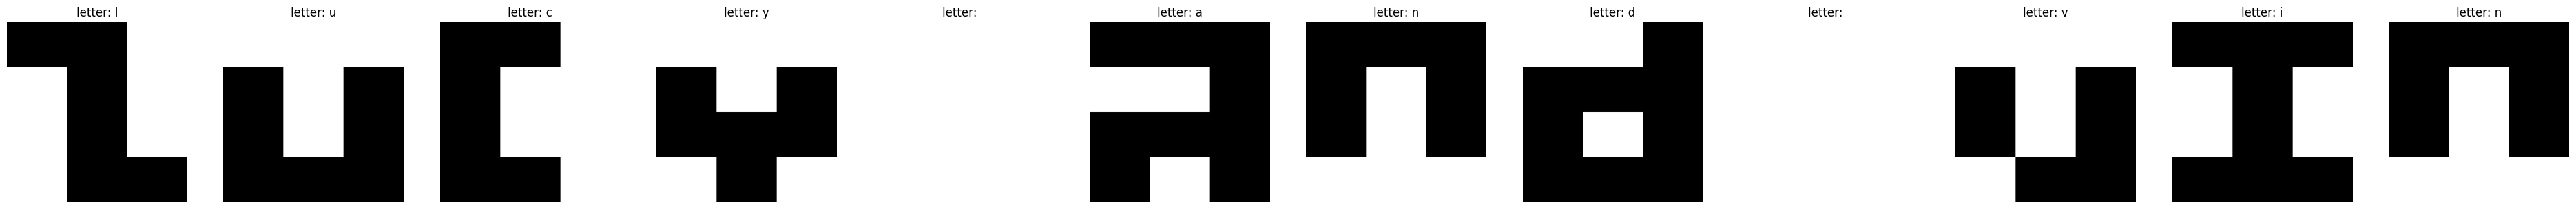

In [257]:
target_sentence = "lucy and vin"


k = len(target_sentence)
fig, ax = plt.subplots(1, k, figsize=(k * 4, 4))
for i, letter in enumerate(target_sentence):
    if letter == " ":
        img = imgs[-1]
    else:
        letter_i = alphabet.index(letter)
        scores = siglip_similarity(letter_features[letter_i], image_features)
        img = imgs[np.argmax(scores)]
    ax[i].imshow(img)
    ax[i].set_title(f"letter: {letter}")
    ax[i].axis("off")